# Figure S2

In [2]:
## Basics
import numpy as np
import pandas as pd
import glob
import mdtraj as md

## Local functions
import sys
sys.path.append("../code/scripts")
import parseaf as paf
import composition as comp

## Plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Arial"

## Colors
cscheme = {'pos':'#0177BB', 'neg':'#CB3627', 'dis':'#828282', 'helix':'#009988', 'sheet':'#EE7733', 'cr':'#AA4499',
          'null':"black"}

In [3]:
# Filepaths
path_to_af_data = "/Volumes/DATA/alphafold/UP000002311_559292_YEAST/"

In [4]:
def get_ss_freqs(seq, counts = False, sort_output = True, gaps = False):
    ss_types = ['C', 'E', 'H']
    
    all_seq_ss = []
    all_seq_freqs = []
    
    # Parse sequence
    seq = list(seq)
    seq_ss, seq_counts = np.unique(seq, return_counts=True)
    zero_freq_ss = np.setxor1d(ss_types, seq_ss)

    seq_ss = np.append(seq_ss, zero_freq_ss)
    seq_freqs = np.append(seq_counts, np.zeros(zero_freq_ss.size))
    if not counts:
        seq_freqs = seq_freqs / len(seq)

    if sort_output:
        seq_freqs_sorted = seq_freqs[seq_ss.argsort()]
        all_seq_freqs.append(seq_freqs_sorted)

    else:
        all_seq_ss.append(seq_ss)
        all_seq_freqs.append(seq_freqs)
    
    if sort_output:
        return(all_seq_freqs)
    else:
        return(all_seq_ss, all_seq_freqs)
    
    
def subcategorybar(X, vals, labs, width=0.8, colors=None):
    n = len(vals)
    _X = np.arange(len(X))
    if colors:
        for i in range(n):
            plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                    width=width/float(n), align="edge", label=labs[i], color=colors[i])
    else:
        for i in range(n):
            plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                    width=width/float(n), align="edge", label=labs[i])
    plt.xticks(_X, X)
    plt.legend()

In [5]:
# Load data
# These data are generated in the associated Figure 2 notebook
hits_disordered_frac = np.loadtxt("../data/af_ss_processed/hits_disordered_frac.txt")
rand_disordered_frac = np.loadtxt("../data/af_ss_processed/rand_disordered_frac.txt")
idr_disordered_frac = np.loadtxt("../data/af_ss_processed/idr_disordered_frac.txt")

hits_conf = np.load("../data/af_ss_processed/hits_conf.npy", allow_pickle=True)
rand_conf = np.load("../data/af_ss_processed/rand_conf.npy", allow_pickle=True)
idr_conf = np.load("../data/af_ss_processed/idr_conf.npy", allow_pickle=True)

hits_ss = np.load("../data/af_ss_processed/hits_ss.npy", allow_pickle=True)
rand_ss = np.load("../data/af_ss_processed/rand_ss.npy", allow_pickle=True)
idr_ss = np.load("../data/af_ss_processed/idr_ss.npy", allow_pickle=True)

In [6]:
hits_conf_ss = []
for i in np.arange(len(hits_ss)):
    try:
        hits_conf_ss.append(hits_ss[i][hits_conf[i]])
    except IndexError:
        print(i)
        continue
hits_conf_ss=np.concatenate(hits_conf_ss).ravel().tolist()

rand_conf_ss = []
for i in np.arange(len(rand_ss)):
    try:
        rand_conf_ss.append(rand_ss[i][rand_conf[i]])
    except IndexError:
        print(i)
        continue
rand_conf_ss=np.concatenate(rand_ss).ravel().tolist()

idr_conf_ss = []
for i in np.arange(len(idr_ss)):
    try:
        idr_conf_ss.append(idr_ss[i][idr_conf[i]])
    except IndexError:
        print(i)
        continue
idr_conf_ss=np.concatenate(idr_ss).ravel().tolist()

In [25]:
# Proportion of total residues that are confidentally predicted
len(hits_conf_ss) / len(np.concatenate(hits_ss))


0.4519515692209654

## A

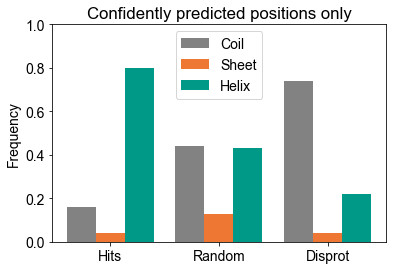

In [8]:
to_plot = np.array([get_ss_freqs(hits_conf_ss)[0], get_ss_freqs(rand_conf_ss)[0], get_ss_freqs(idr_conf_ss)[0]]).T

plt.figure(figsize=(6, 4))
subcategorybar(["Hits", "Random", "Disprot"],
               to_plot,
               labs=['Coil', 'Sheet', 'Helix'], colors=[cscheme['dis'], cscheme['sheet'], cscheme['helix']])

plt.ylabel('Frequency')
plt.title('Confidently predicted positions only')
plt.ylim(0,1)
plt.show()

In [9]:
df = pd.read_csv('../data/charged_regions/cr_raw.csv',
                comment="#")

In [12]:
# Add new columns: secondary structure, confidence, and fraction disordered

def ss_columns(row):
    orf = row['orf']
    uid = row['uni_id']
    seq = row['region.seq']
    
    af_fp = paf.get_alphafold_fp(uid, path_to_af_data)+'.gz'
    try:
        pLDDTs = paf.read_bfactor_from_pdb(af_fp)[row['left.bound']:row['right.bound']+1]
    except FileNotFoundError:
        print(af_fp)
        out = np.empty(4)
        out[:] = np.NaN
        return pd.Series(out)
    
    # Get confidence scores mask
    conf = [True if i > 70. else False for i in pLDDTs]
    
    # Get DSSP predictions
    structure = md.load(af_fp)
    ss = md.compute_dssp(structure, simplified=True)
    region_ss = ss[0][row['left.bound']:row['right.bound']+1]
    
    # Score disorder/order
    region_ss_dis = []
    for r, resid in enumerate(region_ss):
        if conf[r]:
            if resid == "C":
                region_ss_dis.append("D")
            else:
                region_ss_dis.append(resid)
        elif pLDDTs[r] < 50.:
            region_ss_dis.append("D")
        else:
            region_ss_dis.append(np.NaN)
    
    return(pd.Series([pLDDTs, conf, region_ss, region_ss_dis]))

In [13]:
newcols = df.apply(ss_columns, axis=1)
newcols.columns = ["pLDDTs", "Confidence_mask", "DSSP_ss", "Scored_ss"]

newdf = df.join(newcols)

/Users/triandafillou/opt/anaconda3/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-P53288-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-P38811-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-P38811-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-P36022-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-Q12019-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-Q12019-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-Q12019-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-Q12019-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-Q6B0X1-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-Q08428-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-Q12444-F1-model_v1.pdb.gz


,orf,gene,seq.len,left.bound,right.bound,region.seq,region.len,charge.asymmetry,frac.charge,kappa1,kappa2,uni_id,orf_label,pLDDTs,Confidence_mask,DSSP_ss,Scored_ss
0,YAL011W,SWC3,626,0,54,MPAVLRTRSKESSIEQKPASRTRTRSRRGKRGRDDDDDDDDEESDD...,55,0.015674,0.527273,0.297167,0.616928,P31376,verified,"[40.31, 49.1, 48.13, 46.52, 41.9, 44.05, 45.13...","[False, False, False, False, False, False, Fal...","[C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, ...","[D, D, D, D, D, D, D, D, D, nan, D, D, D, D, D..."
1,YAL011W,SWC3,626,169,265,RLFILKNDKIEQKWQDEQELKKKEKELKRKNDAEAKRLRMEERKRQ...,97,0.050753,0.536082,0.051716,0.110243,P31376,verified,"[96.27, 96.56, 95.31, 94.87, 93.11, 90.7, 87.4...","[True, True, True, True, True, True, True, Tru...","[E, E, E, E, E, C, C, H, H, H, H, H, H, H, H, ...","[E, E, E, E, E, D, D, H, H, H, H, H, H, H, H, ..."


In [18]:
def get_p_helix(row):
    scored_ss = row["Scored_ss"]
    try:
        p_helix = ''.join([x for x in scored_ss if x == x]).count("H") / len(scored_ss)
    except TypeError:
        return(np.NaN)
    return(p_helix)


newdf["p_helix"] = newdf.apply(get_p_helix, axis=1)

In [16]:
df_struct_labels = pd.read_csv("../data/charged_regions/cr_filtered_aflabel.csv")
df_struct_labels = pd.merge(df_struct_labels, newdf[["orf", "p_helix", "left.bound"]],\
                            how='left', left_on=["orf", "left.bound"], right_on=['orf', 'left.bound'])

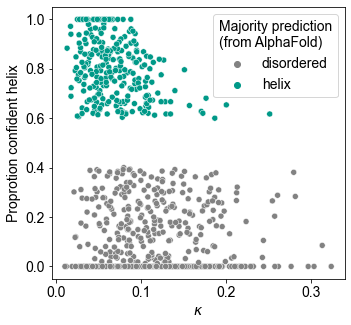

In [24]:
plt.figure(figsize=(5.25,5))
sns.scatterplot(x = "kappa1", y = "p_helix", hue="label", data=df_struct_labels,
                palette=[cscheme["dis"], cscheme["helix"]])
plt.xlabel("$\kappa$")
plt.ylabel("Proprotion confident helix")
plt.legend(title="Majority prediction\n(from AlphaFold)")
plt.show()